<a href="https://colab.research.google.com/github/mrzResearchArena/ACP/blob/master/ACP-240-bit31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [4]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP-500-164.h5
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
bits-164.npy
bits-240.npy
bits-500.npy
bits-740.npy
blosum-164.npy
blosum-240.npy
blosum-500.npy
blosum62-acp240.npy
blosum62-acp740.npy
blosum-740.npy
bpf-164.npy
bpf-240.npy
bpf-500.npy
bpf-740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
dataset-50000.csv
dataset_to_one_hot_vector_representation.pkl
drive/
eight-240.npy
eight-740.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240b.png
model-240-eight.png
model-240.png
model-50000.png
model-500-164.png
model-740-eight.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_se

## [2]. Load Deep Learning API (Keras):

In [ ]:
# # Initialize TF-2.x:
# try:
#     %tensorflow_version 2.x  # Colab only.
# except Exception:
#     pass

# import tensorflow as tf
# print('We\'re using TF-{}.'.format(tf.__version__))

# # Colab Auto Click: [https://paste.ubuntu.com/p/R78fGBJbjb/]

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
We're using TF-2.2.0.


In [5]:
# Deep Neural Networks:
# import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

Using TensorFlow backend.


We're using Keras-2.3.1.


In [6]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

## [3]. Load Datasets:

In [7]:
T = 15 # terminus_length

X1 = np.load('bpf-240.npy')
# X2 = np.load('physico_coded_ACP240_sequences.npy')
X2 = np.load('bits-240.npy')
X3 = np.load('blosum-240.npy')

X1 = X1[:,0:T,:]
X2 = X2[:,0:T,:]
X3 = X3[:,0:T,:]

Y = np.load('ACP240_labels.npy')
Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(240, 15, 20)
(240, 15, 31)
(240, 15, 20)
(240, 2)


In [8]:
X1[0].shape

(15, 20)

## [4]. Generate Model:

In [9]:
def Network():
    ### Head-1:
    input1 = Input(shape=X1[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=X2[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=X3[0].shape)
    
    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head3 = Flatten()(x)


    # merge
    # merge = concatenate(inputs=[head1, head2, head3])
    merge = Concatenate()([head1, head2, head3])

    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.80)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15, 31)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 10)       810         input_1[0][0]                    
____________________________________________________________________________________________

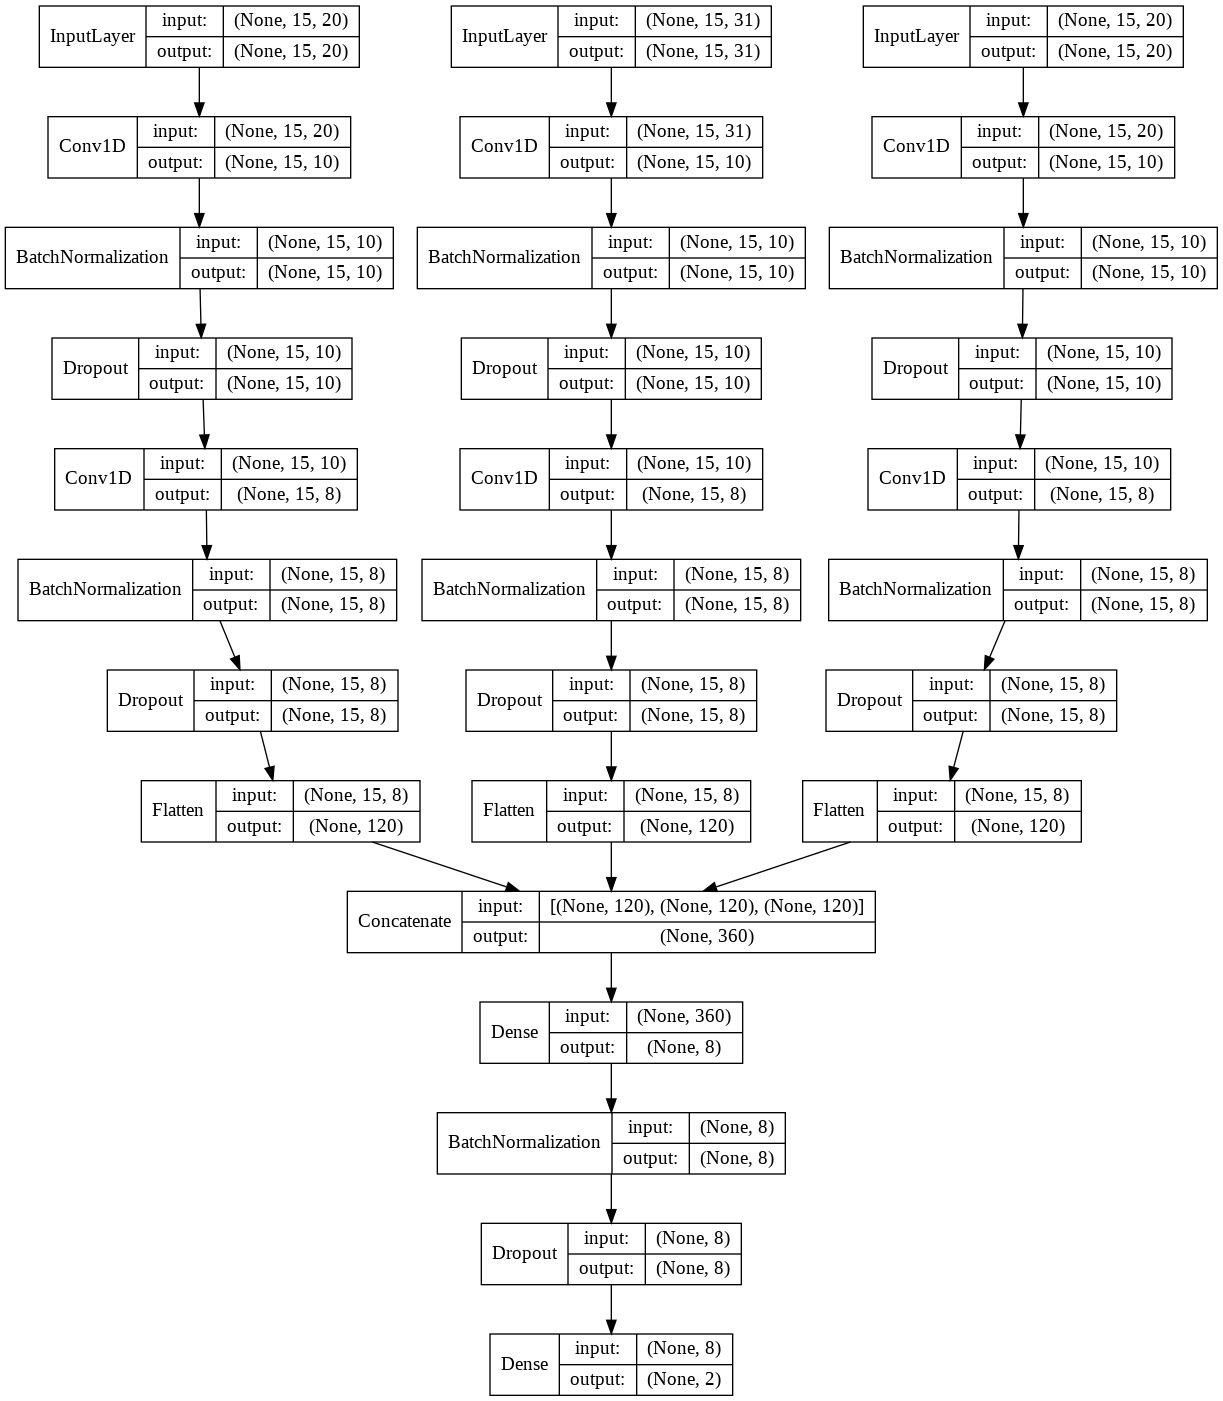

In [10]:
model = Network()
model.summary()
plot_model(model, to_file='model-240.png', show_shapes=True, show_layer_names=False, expand_nested=True)

## [5]. Run Model:

In [ ]:
# earlyStopping = EarlyStopping(patience=25, min_delta=3.0, monitor='val_accuracy', mode='min')
# modelCheckpoint = ModelCheckpoint(verbose=0, filepath = 'modelCheckpoint')

Train on 192 samples, validate on 48 samples
Epoch 1/500
192/192 [==============================] - 3s 16ms/step - loss: 2.0464 - accuracy: 0.4635 - val_loss: 1.6240 - val_accuracy: 0.3958
Epoch 2/500
192/192 [==============================] - 0s 1ms/step - loss: 1.9192 - accuracy: 0.6042 - val_loss: 1.5481 - val_accuracy: 0.4792
Epoch 3/500
192/192 [==============================] - 0s 1ms/step - loss: 2.0507 - accuracy: 0.4896 - val_loss: 1.4684 - val_accuracy: 0.5000
Epoch 4/500
192/192 [==============================] - 0s 1ms/step - loss: 1.7586 - accuracy: 0.5052 - val_loss: 1.3813 - val_accuracy: 0.5208
Epoch 5/500
192/192 [==============================] - 0s 1ms/step - loss: 1.8183 - accuracy: 0.5156 - val_loss: 1.3562 - val_accuracy: 0.5417
Epoch 6/500
192/192 [==============================] - 0s 1ms/step - loss: 1.6197 - accuracy: 0.4948 - val_loss: 1.3696 - val_accuracy: 0.4792
Epoch 7/500
192/192 [==============================] - 0s 1ms/step - loss: 1.7291 - accuracy: 0.

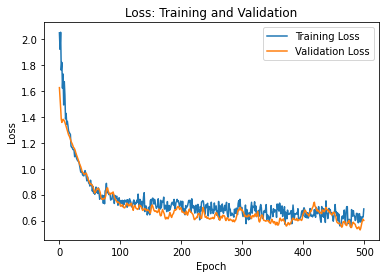

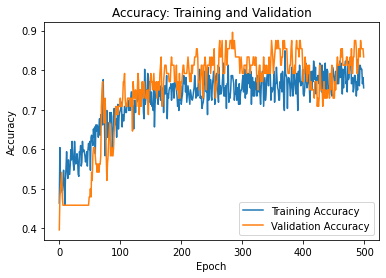

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/500
192/192 [==============================] - 2s 9ms/step - loss: 2.1706 - accuracy: 0.5156 - val_loss: 2.0517 - val_accuracy: 0.3958
Epoch 2/500
192/192 [==============================] - 0s 1ms/step - loss: 2.2479 - accuracy: 0.5312 - val_loss: 1.8572 - val_accuracy: 0.3958
Epoch 3/500
192/192 [==============================] - 0s 1ms/step - loss: 2.2728 - accuracy: 0.4896 - val_loss: 1.5679 - val_accuracy: 0.3958
Epoch 4/500
192/192 [==============================] - 0s 1ms/step - loss: 1.7025 - accuracy: 0.5052 - val_loss: 1.3904 - val_accuracy: 0.5000
Epoch 5/500
192/192 [==============================] - 0s 1ms/step - loss: 1.9722 - accuracy: 0.5573 - val_loss: 1.3557 - val_accuracy: 0.5833
Epoch 6/500
192/192 [==============================] - 0s 1ms/step - loss: 1.8667 - accuracy: 0.4635 - val_loss: 1.3551 - val_accuracy: 0.6042
Epoch 7/500
192/192 [==========================

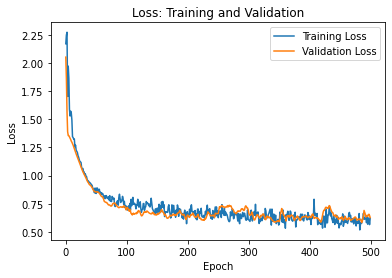

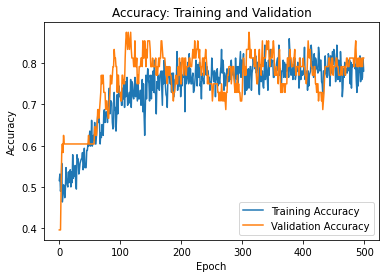

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/500
192/192 [==============================] - 2s 9ms/step - loss: 2.3328 - accuracy: 0.5052 - val_loss: 1.3933 - val_accuracy: 0.5417
Epoch 2/500
192/192 [==============================] - 0s 1ms/step - loss: 2.1435 - accuracy: 0.5417 - val_loss: 1.4094 - val_accuracy: 0.4375
Epoch 3/500
192/192 [==============================] - 0s 1ms/step - loss: 1.7850 - accuracy: 0.5052 - val_loss: 1.4088 - val_accuracy: 0.4375
Epoch 4/500
192/192 [==============================] - 0s 1ms/step - loss: 1.8314 - accuracy: 0.5104 - val_loss: 1.4046 - val_accuracy: 0.4792
Epoch 5/500
192/192 [==============================] - 0s 1ms/step - loss: 1.7094 - accuracy: 0.5521 - val_loss: 1.3802 - val_accuracy: 0.5000
Epoch 6/500
192/192 [==============================] - 0s 1ms/step - loss: 1.8139 - accuracy: 0.5365 - val_loss: 1.3611 - val_accuracy: 0.5208
Epoch 7/500
192/192 [==========================

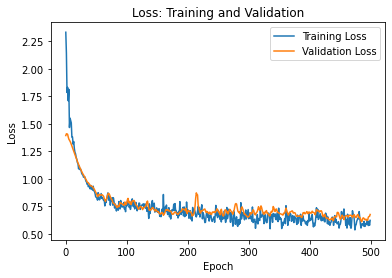

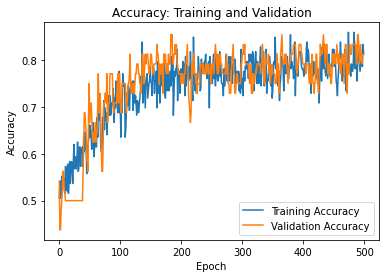

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/500
192/192 [==============================] - 2s 9ms/step - loss: 1.6081 - accuracy: 0.5417 - val_loss: 1.3697 - val_accuracy: 0.5625
Epoch 2/500
192/192 [==============================] - 0s 1ms/step - loss: 1.4670 - accuracy: 0.5677 - val_loss: 1.3545 - val_accuracy: 0.6042
Epoch 3/500
192/192 [==============================] - 0s 1ms/step - loss: 1.4536 - accuracy: 0.5365 - val_loss: 1.3399 - val_accuracy: 0.6250
Epoch 4/500
192/192 [==============================] - 0s 1ms/step - loss: 1.4710 - accuracy: 0.5000 - val_loss: 1.3183 - val_accuracy: 0.5833
Epoch 5/500
192/192 [==============================] - 0s 1ms/step - loss: 1.3114 - accuracy: 0.6094 - val_loss: 1.2933 - val_accuracy: 0.5833
Epoch 6/500
192/192 [==============================] - 0s 1ms/step - loss: 1.2968 - accuracy: 0.5573 - val_loss: 1.2653 - val_accuracy: 0.5000
Epoch 7/500
192/192 [==========================

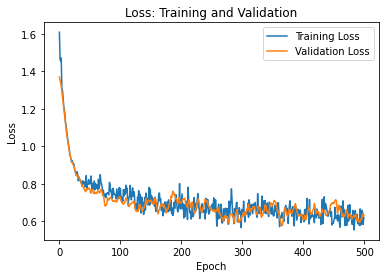

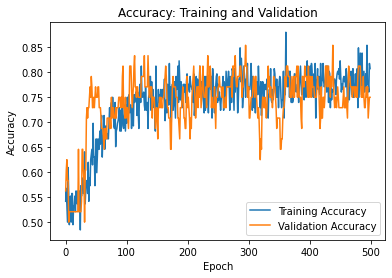

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/500
192/192 [==============================] - 2s 9ms/step - loss: 2.5554 - accuracy: 0.4792 - val_loss: 1.4564 - val_accuracy: 0.4167
Epoch 2/500
192/192 [==============================] - 0s 1ms/step - loss: 2.4368 - accuracy: 0.5677 - val_loss: 1.5220 - val_accuracy: 0.4167
Epoch 3/500
192/192 [==============================] - 0s 1ms/step - loss: 2.4685 - accuracy: 0.5052 - val_loss: 1.5090 - val_accuracy: 0.4375
Epoch 4/500
192/192 [==============================] - 0s 1ms/step - loss: 2.2525 - accuracy: 0.5052 - val_loss: 1.4505 - val_accuracy: 0.3958
Epoch 5/500
192/192 [==============================] - 0s 1ms/step - loss: 2.0088 - accuracy: 0.5729 - val_loss: 1.4124 - val_accuracy: 0.5000
Epoch 6/500
192/192 [==============================] - 0s 1ms/step - loss: 1.8762 - accuracy: 0.5156 - val_loss: 1.3847 - val_accuracy: 0.5833
Epoch 7/500
192/192 [==========================

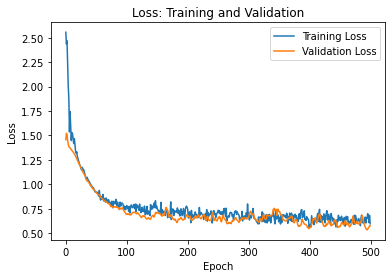

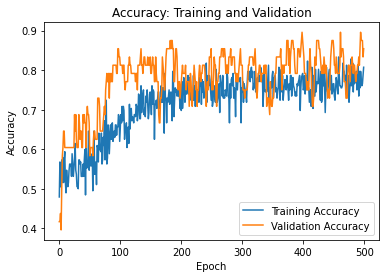

#################################################
[0.8333333134651184, 0.8125, 0.8125, 0.75, 0.8541666865348816]
Accuracy: 0.81
Sensitivity: 0.8689
Specificity: 0.7494
MCC: 0.6254
Precision: 0.8006


In [11]:
setEpochNumber     = 500     # 250 performed well.
setBatchSizeNumber = 16
####################################################

cv = KFold(n_splits=5, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=[X1[train,:,:], X2[train,:,:], X3[train,:,:]], y=[Y[train,:]],
                        validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:]], [Y[test,:]]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        verbose=1,
                        callbacks=[])
    # results = model.fit(x=X2[train,:,:], y=Y[train,:],
    #                     validation_data=(X2[test,:,:], Y[test,:]),
    #                     batch_size=setBatchSizeNumber, epochs=setEpochNumber,
    #                     verbose=1,
    #                     callbacks=[])

    # Evaluate the Model:
    accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:], batch_size=setBatchSizeNumber)
    # accuracy = model.evaluate(x=X2[test,:,:], y=Y[test,:], batch_size=setBatchSizeNumber)
    Accuracy.append(accuracy[1])
    
    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    
    # Performance Plot
    print('#################################################')
    print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    lossPlot(results)
    accuracyPlot(results)
    print('#################################################')
#end-for

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))